## Setup

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

%cd /content
%ls -l -h

/content
total 22G
-rw-r--r--    1 root root 122M Apr  3 20:41 data.csv
-rw-r--r--    1 root root 1.7M Mar 29 19:01 Dataset_3_20_2024.csv
-rw-r--r--    1 root root  21G Apr 14 16:30 Dataset.zip
drwxr-xr-x   11 root root 4.0K Apr 14 17:11 disk2/
drwxr-xr-x    4 root root 4.0K Apr 15 02:09 eric_cache/
-rw-r--r--    1 root root  49M Mar 29 19:35 labeled_data.csv
-rw-r--r--    1 root root 1.7M Mar 27 20:11 labels.csv
drwxr-xr-x    4 root root 4.0K Apr 23 01:44 model_1_a.model/
-rw-r--r--    1 root root  114 Apr 19 19:49 model_history1.pkl
-rw-r--r--    1 root root   96 Apr 19 18:37 model_history.pkl
-rw-r--r--    1 root root  114 Apr 20 20:56 model_resnext_history2.pkl
-rw-r--r--    1 root root  168 Apr 20 22:02 model_resnext_history3.pkl
-rw-r--r--    1 root root  114 Apr 20 20:17 model_resnext_history.pkl
drwxr-xr-x 1465 root root  36K Mar 16 23:00 PPMI_test/
drwxr-xr-x    1 root root 4.0K Feb  5 20:33 sample_data/
drwxr-xr-x    3 root root 4.0K Apr 22 15:59 shree_cache/
drwxr-xr-x   12 

In [3]:
%ls disk2 -l -h -r

total 144K
-rw-r--r--    1 root root  64K Nov 18 16:51 vmlinuz_hd.vblock
drwxr-xr-x   10 root root 4.0K Nov 18 16:28 var_overlay/
drwxr-xr-x    9 root root 4.0K Apr 23 15:58 var/
drwxr-xr-x 1465 root root  36K Apr 14 17:19 PPMI/
drwxr-xr-x    4 root root 4.0K Apr  8 12:07 model_1.model/
drwxr-xr-x    4 root root 4.0K Apr  9 04:05 model_1_a.model/
drwx------    2 root root  16K Nov 18 16:26 lost+found/
drwxr-xr-x    7 root root 4.0K Apr 13 21:56 home/
drwxr-xr-x    3 root root 4.0K Mar 16 22:35 etc/
drwxr-xr-x    5 root root 4.0K Nov 18 16:32 dev_image/


In [4]:
# check disk usage
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         193G  188G  5.5G  98% /
tmpfs            64M     0   64M   0% /dev
shm             5.5G     0  5.5G   0% /dev/shm
/dev/sda1       193G  188G  5.5G  98% /opt/bin
tmpfs            15G  1.2M   15G   1% /var/colab
/dev/sdb1       193G   66G  128G  34% /content/disk2


In [5]:
# see where is demanding most storage
!du -h /content | sort -rh | head -n 10

165G	/content
66G	/content/disk2
64G	/content/PPMI_test
64G	/content/disk2/PPMI
15G	/content/silvia_cache
3.1G	/content/silvia_cache/model_parnet_more_epochs.model/variables
3.1G	/content/silvia_cache/model_parnet_more_epochs.model
3.1G	/content/silvia_cache/model_parnet.model/variables
3.1G	/content/silvia_cache/model_parnet.model
3.1G	/content/silvia_cache/model_parnet_7epochs.model/variables


In [6]:
#!pip install pydicom

In [7]:
from PIL import Image
import dask.dataframe as dd
import os
import pydicom as dicom

from tensorflow import keras

from keras import Sequential
from keras.layers import Dense, Flatten, Conv3D, Conv2D, MaxPooling3D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

## GPU Information

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  #For GPU tunning

Tue Apr 23 16:04:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')
  #FOR ram tunning

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Data processing

In [9]:
label_df = pd.read_csv('Dataset_3_20_2024.csv')
label_df['Subject'] = label_df['Subject'].astype(str)

# Create a dictionary where the key is the Subject and the value is the Group
group_mapping = label_df.set_index('Subject')['Group'].to_dict()

label_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I495208,92834,Prodromal,M,66,BL,MRI,MPRAGE GRAPPA2,Original,3/20/2015,DCM,NaN
1,I495209,92834,Prodromal,M,66,BL,MRI,Axial T2 TSE with Fat Sat,Original,3/20/2015,DCM,NaN
2,I440709,91837,Prodromal,M,74,BL,MRI,AX DUAL_TSE,Original,3/04/2014,DCM,NaN
3,I440711,91837,Prodromal,M,74,BL,MRI,Cor FLAIR TI_2800ms,Original,3/04/2014,DCM,NaN
4,I440710,91837,Prodromal,M,74,BL,MRI,SAG 3D T1,Original,3/04/2014,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17437,I1473172,100001,PD,M,67,BL,MRI,SAG 3D MPRAGE,Original,10/07/2020,DCM,NaN
17438,I1473183,100001,PD,M,67,BL,MRI,AX T2 GRE MT,Original,10/07/2020,DCM,NaN
17439,I1658557,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN
17440,I1658550,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN


In [ ]:
### get all image files and their attributes

DATA_DIR = '/content/disk2/PPMI'

file_data = []
for subj_id in os.listdir(DATA_DIR):
  for imaging_method in os.listdir(os.path.join(DATA_DIR, subj_id)):
    for date in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method)):
      for im_id in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date)):
        for image_name in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id)):
          absolute_path = os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id, image_name)
          file_data.append({
              'Subject': subj_id,
              'imaging_method': imaging_method,
              'date_str': date,
              'Image Data ID': im_id,
              'file_name': image_name,
              'full_path': absolute_path
          })
fileinfo_df = pd.DataFrame(file_data)

# map the Group values to fileinfo_df
fileinfo_df['Group'] = fileinfo_df['Subject'].map(group_mapping)

# map Group to labels
fileinfo_df['label'] = fileinfo_df['Group'].map(lambda s: {'PD': 0, 'Prodromal': 1, 'Control': 2}.get(s, -1))

fileinfo_df

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
0,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
1,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
2,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
3,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
4,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
...,...,...,...,...,...,...,...,...
403167,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403168,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403169,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403170,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0


In [ ]:
### statistics
for col in fileinfo_df:
  print(col, fileinfo_df[col].unique().size)

print()
print(fileinfo_df['label'].value_counts())

print()
print(fileinfo_df['imaging_method'].value_counts())

Subject 1463
imaging_method 214
date_str 1873
Image Data ID 2238
file_name 455026
full_path 455026
Group 4
label 4

 1    229880
 0    195993
 2     28224
-1       929
Name: label, dtype: int64

R_L_RESTING_STATE_FMRI_ep2d_fid_basic_bold    153600
rsfMRI_RL                                      38712
Resting_State_fMRI_R_L                         21120
MPRAGE_GRAPPA                                  20416
DTI_LR                                         13233
                                               ...  
DTI_RL_ColFA                                       1
Coronal                                            1
Transverse                                         1
DTI_LR_TENSOR_B0                                   1
DTI_RL_TRACEW                                      1
Name: imaging_method, Length: 214, dtype: int64


In [ ]:
### image scan types
# Sagittal, Coronal, and Axial parts of the brain

scantype_indicators = {
    'sagittal': 'sag',
    'axial': 'ax',
    'coronal': 'cor',
}
scantype_counts = {scantype: 0 for scantype in scantype_indicators.keys()}
scantype_counts['unknown'] = 0

for desc in fileinfo_df['imaging_method']:
  types_assigned = 0

  # check established types
  for scantype, indicator in scantype_indicators.items():
    if indicator in desc.lower():
      scantype_counts[scantype] += 1
      types_assigned += 1

  # if nothing assigned, assign unknown
  if types_assigned == 0:
    scantype_counts['unknown'] += 1
  # if multiple assigned, print to debug
  if types_assigned >= 2:
    print(desc)

scantype_counts

{'sagittal': 33304, 'axial': 23764, 'coronal': 617, 'unknown': 397341}

In [ ]:
### filter data down to MPRAGE_GRAPPA images
#data_df = fileinfo_df[fileinfo_df['imaging_method'].apply(lambda s: 'ax' in s.lower())]
data_df = fileinfo_df[fileinfo_df['imaging_method'] == 'MPRAGE_GRAPPA']
display(data_df)

### statistics
for col in data_df:
  print(col, data_df[col].unique().size)

print()
print(data_df['label'].value_counts())

print()
print(data_df['imaging_method'].value_counts())

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
48,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
49,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
50,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
51,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
52,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
...,...,...,...,...,...,...,...,...
452810,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452811,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452812,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452813,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0


Subject 109
imaging_method 1
date_str 115
Image Data ID 116
file_name 20416
full_path 20416
Group 3
label 3

0    12128
2     4416
1     3872
Name: label, dtype: int64

MPRAGE_GRAPPA    20416
Name: imaging_method, dtype: int64


Image shape: (256, 256)


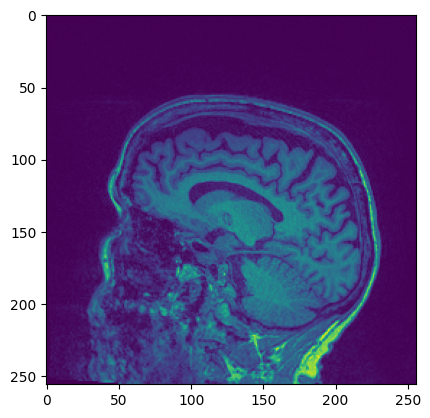

In [ ]:
### preview sample image
pixels = dicom.dcmread(data_df['full_path'].iloc[8000]).pixel_array
print('Image shape:', pixels.shape)
plt.imshow(pixels);

In [ ]:
### validate shapes of all samples
sample_shapes = {}
for i, full_path in enumerate(data_df['full_path']):
  pixels = dicom.dcmread(full_path).pixel_array
  sample_shape = pixels.shape

  if sample_shape not in sample_shapes:
    sample_shapes[sample_shape] = 1
  else:
    sample_shapes[sample_shape] += 1

  if i % 5000 == 0:
    print(f"Image {i} processed")

sample_shapes

Image 0 processed
Image 5000 processed
Image 10000 processed
Image 15000 processed
Image 20000 processed


{(256, 240): 15648, (256, 256): 4768}

## Model Input

In [ ]:
def path_to_pixels(full_path):
  """load image from path, expected to be either (256, 256), or (256, 240), in which case pad to (256, 256)"""
  # load pixels
  ds = dicom.dcmread(full_path).pixel_array
  assert (ds.shape == (256, 256)) or (ds.shape == (256, 240))

  # reshape to (256, 256)
  pad_cols = int((256 - ds.shape[1]) / 2)
  assert (pad_cols == 0) or (pad_cols == 8)
  ds_padded = np.pad(ds, ((0, 0), (pad_cols, pad_cols)), 'constant')
  assert ds_padded.shape == (256, 256)

  return ds_padded

In [ ]:
### get X (pixels) and y

X = []
y = []
for label, full_path in zip(data_df['label'], data_df['full_path']):
  X.append(path_to_pixels(full_path))
  y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
# one hot encode
from keras.utils import to_categorical
y_onehot = to_categorical(y)

In [ ]:
#np.save('/content/eric_cache/X.npy', X)
#np.save('/content/eric_cache/y.npy', y)

In [10]:
#X = np.load('/content/eric_cache/X.npy')
#y = np.load('/content/eric_cache/y.npy')

# use Silvia's cache instead since mine got deleted
X = np.load('/content/silvia_cache/X.npy')
y = np.load('/content/silvia_cache/y.npy')

In [11]:
display(X.shape)
display(y.shape)

(20416, 256, 256)

(20416,)

In [12]:
# train validation test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=17)
del X
del y
y_train_onehot, y_val_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

display(X_train.shape)
display(y_train.shape)
display(y_train_onehot.shape)
display(X_val.shape)
display(y_val.shape)
display(y_val_onehot.shape)
display(X_test.shape)
display(y_test.shape)
display(y_test_onehot.shape)

(12249, 256, 256)

(12249,)

(12249, 3)

(4083, 256, 256)

(4083,)

(4083, 3)

(4084, 256, 256)

(4084,)

(4084, 3)

## Training/Testing Model_2

v2 is trained with 5 epochs

v3 uses a validation set and tunes epochs

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

def Conv_2D_Block(x, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def grouped_convolution_block(x, num_filters, cardinality, strides):
    if cardinality == 1:
        return Conv_2D_Block(x, num_filters, (3, 3), strides)

    filters_per_group = num_filters // cardinality
    groups = []
    for j in range(cardinality):
        group = Conv_2D_Block(x, filters_per_group, (3, 3), strides)
        groups.append(group)

    x = Concatenate()(groups)
    return x

def residual_block(x, num_filters, cardinality, strides=(1, 1)):
    shortcut = x
    x = Conv_2D_Block(x, num_filters, (1, 1))
    x = grouped_convolution_block(x, num_filters, cardinality, strides)
    x = Conv_2D_Block(x, num_filters * 4, (1, 1))

    shortcut = Conv2D(num_filters * 4, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_ResNeXt(input_shape, num_classes, cardinality=32):
    inputs = Input(shape=input_shape)
    x = Conv_2D_Block(inputs, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 1 (You can adjust the number of residual blocks as required)
    x = residual_block(x, 128, cardinality)
    x = residual_block(x, 128, cardinality)

    # You can add more stages here

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Parameters
input_shape = (256, 256, 1)  # Grayscale images
num_classes = 3  # Parkinson's, Prodromal, Control

# Build and compile model
model = build_ResNeXt(input_shape, num_classes, cardinality=32)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         3200      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [14]:
from tensorflow.keras import mixed_precision

# Set the global policy to mixed_float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Compile the model again with the new policy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=4,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/4
12249/12249 [==============================] - 597s 45ms/step - loss: 0.9851 - accuracy: 0.5867
Epoch 2/4
12249/12249 [==============================] - 556s 45ms/step - loss: 0.9589 - accuracy: 0.5895
Epoch 3/4
12249/12249 [==============================] - 546s 45ms/step - loss: 0.9488 - accuracy: 0.5895
Epoch 4/4
12249/12249 [==============================] - 544s 44ms/step - loss: 0.9187 - accuracy: 0.5888


In [17]:
model.save('/content/silvia_cache/model_resnext.model')

In [18]:
import pickle
with open('model_resnext_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [19]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 36s 9ms/step - loss: 1.0785 - accuracy: 0.5939


[1.0784518718719482, 0.5939260125160217]

In [20]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 36s 9ms/step - loss: 1.1065 - accuracy: 0.5869


[1.106512188911438, 0.5869246125221252]

In [1]:
from keras.models import load_model

In [22]:
model = load_model('/content/silvia_cache/model_resnext.model')

In [23]:
history_2 = model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=4,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/4
12249/12249 [==============================] - 595s 45ms/step - loss: 0.8747 - accuracy: 0.6033
Epoch 2/4
12249/12249 [==============================] - 560s 46ms/step - loss: 0.8251 - accuracy: 0.6149
Epoch 3/4
12249/12249 [==============================] - 558s 46ms/step - loss: 0.7568 - accuracy: 0.6630
Epoch 4/4
12249/12249 [==============================] - 518s 42ms/step - loss: 0.7013 - accuracy: 0.6867


In [27]:
model.save('/content/silvia_cache/model_resnext_2.model')

In [24]:
import pickle
with open('model_resnext_history2.pkl', 'wb') as file:
    pickle.dump(history_2.history, file)

In [25]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 35s 8ms/step - loss: 1.3201 - accuracy: 0.3373


[1.3201159238815308, 0.33725202083587646]

In [26]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 34s 8ms/step - loss: 1.3147 - accuracy: 0.3472


[1.3147249221801758, 0.3472086191177368]

In [28]:
model = load_model('/content/silvia_cache/model_resnext_2.model')

In [29]:
history_3 = model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=7,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/7
12249/12249 [==============================] - 556s 42ms/step - loss: 0.6492 - accuracy: 0.7120
Epoch 2/7
12249/12249 [==============================] - 520s 42ms/step - loss: 0.5934 - accuracy: 0.7388
Epoch 3/7
12249/12249 [==============================] - 519s 42ms/step - loss: 0.5503 - accuracy: 0.7569
Epoch 4/7
12249/12249 [==============================] - 524s 43ms/step - loss: 0.5083 - accuracy: 0.7783
Epoch 5/7
12249/12249 [==============================] - 532s 43ms/step - loss: 0.4797 - accuracy: 0.7952
Epoch 6/7
12249/12249 [==============================] - 534s 44ms/step - loss: 0.4356 - accuracy: 0.8161
Epoch 7/7
12249/12249 [==============================] - 555s 45ms/step - loss: 0.4079 - accuracy: 0.8289


In [30]:
model.save('/content/silvia_cache/model_resnext_3.model')

In [32]:
import pickle
with open('model_resnext_history3.pkl', 'wb') as file:
    pickle.dump(history_3.history, file)

In [33]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 36s 8ms/step - loss: 1.9702 - accuracy: 0.2755


[1.970174789428711, 0.27553269267082214]

In [34]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 34s 8ms/step - loss: 1.9541 - accuracy: 0.2855


[1.9541339874267578, 0.28550440073013306]

## Figures

In [36]:
import pickle

# Load the first training history
with open('model_resnext_history.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Load the second training history
with open('model_resnext_history2.pkl', 'rb') as file:
    history2 = pickle.load(file)
# Load the second training history
with open('model_resnext_history3.pkl', 'rb') as file:
    history3 = pickle.load(file)


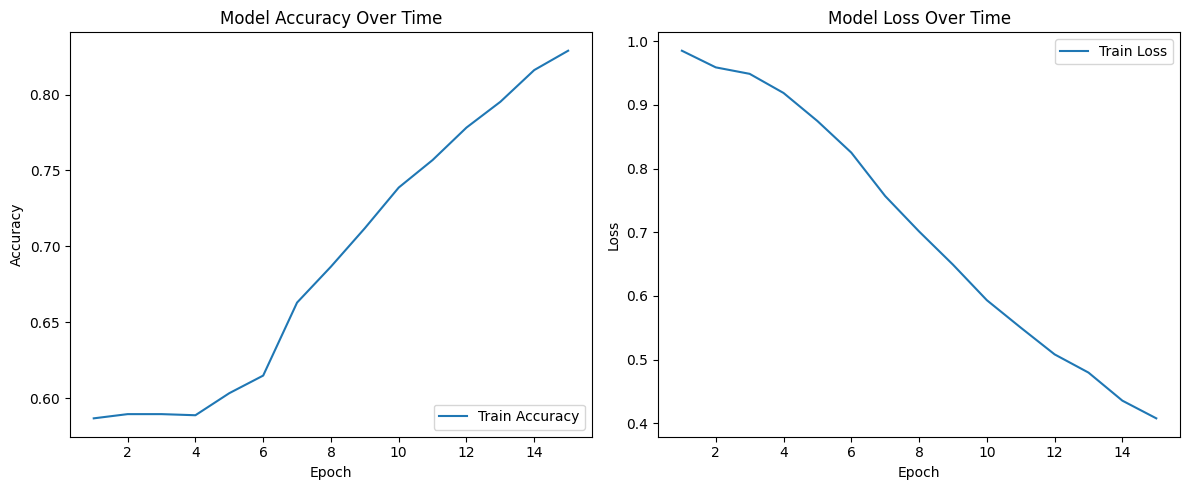

In [37]:
import matplotlib.pyplot as plt

# Assuming 'history1' and 'history2' have been loaded as shown previously

# Concatenate the metrics from both histories
def concat_histories(key):
    return history1[key] + history2[key] + history3[key]  # Combine lists from both training sessions

# Prepare concatenated data
accuracy = concat_histories('accuracy')
val_accuracy = concat_histories('val_accuracy') if 'val_accuracy' in history1 else None
loss = concat_histories('loss')
val_loss = concat_histories('val_loss') if 'val_loss' in history1 else None

# Calculate the epoch numbers for better plotting
epochs = list(range(1, len(accuracy) + 1))

# Plot training and validation accuracy for concatenated histories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, accuracy, label='Train Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss for concatenated histories
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, loss, label='Train Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


In [13]:
model = load_model('/content/silvia_cache/model_resnext_3.model')

128/128 [==============================] - 25s 163ms/step


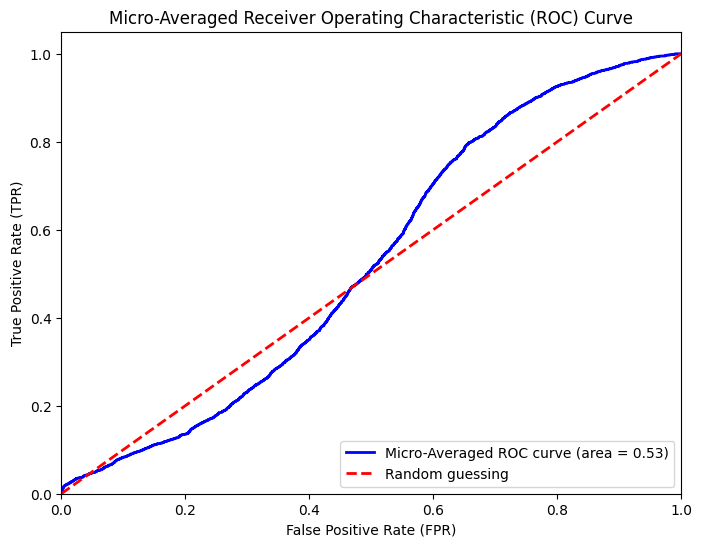

In [14]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


# Make predictions
y_pred = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute micro-averaged ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='blue', lw=2, label='Micro-Averaged ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


128/128 [==============================] - 20s 159ms/step


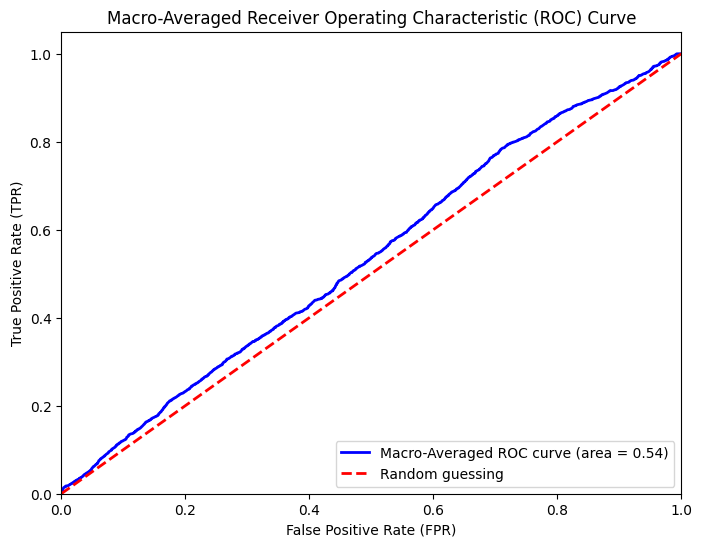

In [15]:


# Make predictions
y_pred = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]
fpr_macro = dict()
tpr_macro = dict()
roc_auc_macro = dict()
for i in range(n_classes):
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

# Compute macro-averaged ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
mean_tpr /= n_classes
fpr_macro["macro"] = all_fpr
tpr_macro["macro"] = mean_tpr
roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

# Plot macro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_macro["macro"], tpr_macro["macro"], color='blue', lw=2, label='Macro-Averaged ROC curve (area = %0.2f)' % roc_auc_macro["macro"])
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


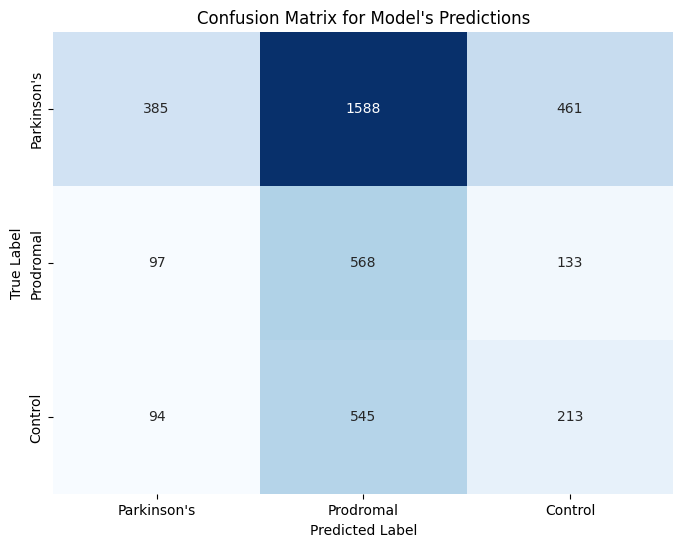

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
#y_pred = model.predict(X_test)

# If 'y_test' contains direct class labels, use it directly
y_true_classes = y_test  # Use directly if y_test is already class labels

# Get the class predictions for the entire test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
plt.show()


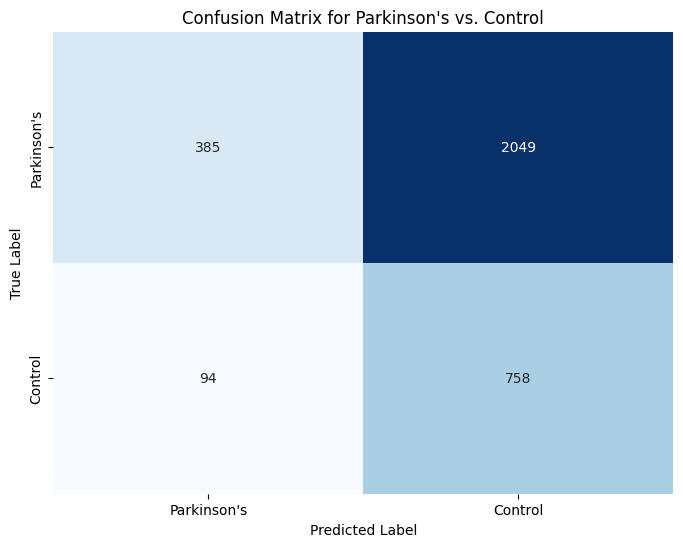

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# Filter instances where y_test is either 0 (Parkinson's) or 2 (Control)
indices = (y_test == 0) | (y_test == 2)
y_test_filtered = y_test[indices]
y_pred_filtered = y_pred[indices]

# Map Control label from 2 to 1 for binary classification
y_test_filtered = np.where(y_test_filtered == 2, 1, y_test_filtered)
y_pred_filtered_classes = np.argmax(y_pred_filtered, axis=1)
y_pred_filtered_classes = np.where(y_pred_filtered_classes == 2, 1, y_pred_filtered_classes)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_test_filtered, y_pred_filtered_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Parkinson's vs. Control")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Control'])
plt.show()


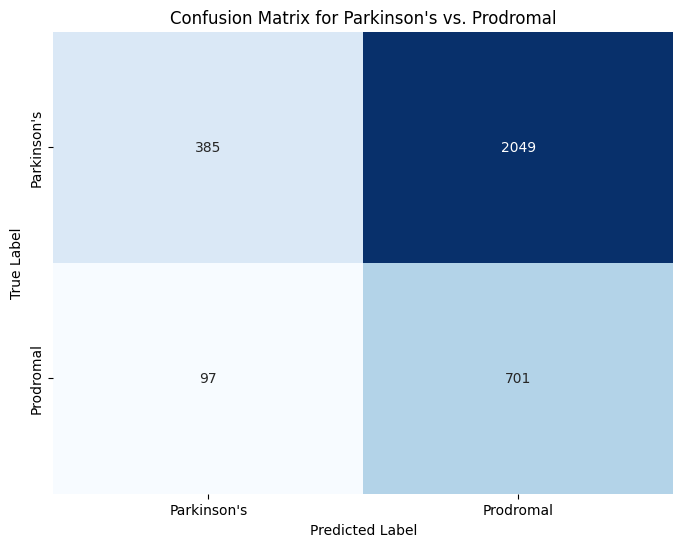

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# Filter instances where y_test is either 0 (Parkinson's) or 2 (Control)
indices = (y_test == 0) | (y_test == 1)
y_test_filtered = y_test[indices]
y_pred_filtered = y_pred[indices]

# Map Control label from 2 to 1 for binary classification
y_test_filtered = np.where(y_test_filtered == 2, 1, y_test_filtered)
y_pred_filtered_classes = np.argmax(y_pred_filtered, axis=1)
y_pred_filtered_classes = np.where(y_pred_filtered_classes == 2, 1, y_pred_filtered_classes)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_test_filtered, y_pred_filtered_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Parkinson's vs. Prodromal")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal'])
plt.show()